#**Filter2Noise: Interpretable Single Low-Dose CT Image Denoising**



### Importing Libraries and Setting Up the Environment


In [1]:
#!pip install loguru

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from loguru import logger
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

def setup_environment(seed=77):
    """
    Set random seeds and configure the CUDA environment if available.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def setup_logger():
    """
    Configure logging settings for the loguru logger.
    """
    logger.remove()
    logger.add(sys.stderr,
               format="<green>{time:YYYY-MM-DD HH:mm:ss.SSS}</green> | "
                      "<level>{level: <8}</level> | <cyan>{name}</cyan>:"
                      "<cyan>{function}</cyan>:<cyan>{line}</cyan> - <level>{message}</level>")


### Utility Functions for Image Processing


In [15]:
def prepare_image(image, device='cpu'):
    """
    Convert a numpy array or torch.Tensor to a 4D float Tensor on the specified device.
    """
    if isinstance(image, np.ndarray):
        tensor = torch.from_numpy(image).float()
    elif isinstance(image, torch.Tensor):
        tensor = image.float()
    else:
        raise TypeError("Unsupported image type: {}".format(type(image)))
    if tensor.dim() == 2:
        tensor = tensor.unsqueeze(0).unsqueeze(0)
    elif tensor.dim() == 3:
        tensor = tensor.permute(2, 0, 1).unsqueeze(0)
    else:
        raise ValueError("Unsupported image shape: {}".format(tensor.shape))
    print("min, max, mean",torch.min(tensor), torch.max(tensor), torch.mean(tensor))
    return tensor.to(device)

def restore_image(tensor):
    """
    Convert a 4D Tensor (NCHW) back to a numpy array in HWC or HW format.
    """
    if tensor.shape[1] == 1:
        return tensor.squeeze().cpu().numpy()
    else:
        return tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

def Downsampler(img):
    """
    Downsample an image into two outputs using a fixed 2×2 stride-2 convolution.
    """
    c = img.shape[1]
    device = img.device
    filter1 = torch.FloatTensor([[[[0, 0.5], [0.5, 0]]]]).to(device).repeat(c, 1, 1, 1)
    filter2 = torch.FloatTensor([[[[0.5, 0], [0, 0.5]]]]).to(device).repeat(c, 1, 1, 1)
    output1 = F.conv2d(img, filter1, stride=2, groups=c)
    output2 = F.conv2d(img, filter2, stride=2, groups=c) 
    # groups means how the input channels are split into independent groups, so the shape of each group can match the shape of filter
    return output1, output2

def ELS(img):
    """
    For each 2×2 block in the input tensor, identify the pair of pixels with the smallest
    Euclidean distance and swap them.

    Returns:
        torch.Tensor: Image with the closest pair in each block swapped.
    """
    B, C, H, W = img.shape
    assert (H % 2 == 0) and (W % 2 == 0), "Height and Width must be even."
    # Unfold image into 2×2 blocks: [B, C, H//2, W//2, 2, 2]
    blocks = img.unfold(2, 2, 2).unfold(3, 2, 2).permute(0, 2, 3, 1, 4, 5)
    M = B * (H // 2) * (W // 2)
    # Flatten each block to shape [M, 4, C]
    flat_blocks = blocks.reshape(M, C, 2, 2).permute(0, 2, 3, 1).reshape(M, 4, C)
    # Compute pairwise squared distances: [M, 4, 4]
    diff = flat_blocks.unsqueeze(2) - flat_blocks.unsqueeze(1)
    dists = (diff ** 2).sum(dim=-1)
    eye_mask = torch.eye(4, device=img.device, dtype=bool).unsqueeze(0)
    dists_min = dists.masked_fill(eye_mask, float("inf"))
    idx_min = torch.argmin(dists_min.view(M, -1), dim=1)
    p_min = idx_min // 4
    q_min = idx_min % 4
    swapped_blocks = flat_blocks.clone()
    batch_indices = torch.arange(M, device=img.device)
    temp = swapped_blocks[batch_indices, p_min, :].clone()
    swapped_blocks[batch_indices, p_min, :] = swapped_blocks[batch_indices, q_min, :]
    swapped_blocks[batch_indices, q_min, :] = temp
    # Reshape back to [B, C, H, W]
    x = swapped_blocks.view(M, 2, 2, C).permute(0, 3, 1, 2)
    x = x.view(B, H // 2, W // 2, C, 2, 2).permute(0, 3, 1, 4, 2, 5).contiguous().view(B, C, H, W)
    return x

def prepare_image_for_display(img):
    """
    Convert an image (HWC or HW) in [0,1] to a 4D Tensor in [-1,1].
    """
    if img.ndim == 2:
        img = np.expand_dims(img, axis=2)
    if img.shape[2] == 1:
        img = np.repeat(img, 3, axis=2)
    img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
    return img_tensor.float() * 2 - 1

def prepare_for_display(img):
    """
    Prepare an image for display. For numpy arrays, if the image has a singleton dimension
    (either the batch dimension or the third dimension), squeeze it.
    """
    if isinstance(img, np.ndarray):
        if img.ndim == 3 and (img.shape[0] == 1 or img.shape[2] == 1):
            return np.squeeze(img)
        return img
    else:
        return img.squeeze(0) if img.shape[0] == 1 else img


### Plotting Functions

In [3]:
def plot_results(original, noisy, denoised, metrics, save_path=None):
    """
    Plot original, noisy, and denoised images with corresponding PSNR and SSIM.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    original_disp = prepare_for_display(original)
    noisy_disp = prepare_for_display(noisy)
    denoised_disp = prepare_for_display(denoised)
    cmap = 'gray' if original_disp.ndim == 2 else None

    axes[0].imshow(original_disp, cmap=cmap)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(noisy_disp, cmap=cmap)
    axes[1].set_title("Noisy\nPSNR: {:.2f} dB\nSSIM: {:.4f}".format(metrics['psnr_noisy'], metrics['ssim_noisy']))
    axes[1].axis('off')

    axes[2].imshow(denoised_disp, cmap=cmap)
    axes[2].set_title("Denoised\nPSNR: {:.2f} dB\nSSIM: {:.4f}".format(metrics['psnr_denoised'], metrics['ssim_denoised']))
    axes[2].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, 'results_with_metrics_pixel.png'),
                    bbox_inches='tight', dpi=300)
    plt.show()

    
def plot_sigmas(sigmas_list, save_path=None):
    """
    Plot sigma values (sigma_x, sigma_y, sigma_r) for each stage.
    """
    num_stages = len(sigmas_list)
    fig, axes = plt.subplots(num_stages, 3, figsize=(15, 5 * num_stages))
    if num_stages == 1:
        axes = [axes]
    for stage_idx, sigmas in enumerate(sigmas_list):
        sigma_sx = sigmas[..., 0].cpu().numpy()
        sigma_sy = sigmas[..., 1].cpu().numpy()
        sigma_r = sigmas[..., 2].cpu().numpy()

        im0 = axes[stage_idx][0].imshow(sigma_sx.squeeze(), cmap='jet')
        axes[stage_idx][0].set_title("Stage {}\nSigma_x".format(stage_idx + 1))
        plt.colorbar(im0, ax=axes[stage_idx][0], fraction=0.046, pad=0.04)

        im1 = axes[stage_idx][1].imshow(sigma_sy.squeeze(), cmap='jet')
        axes[stage_idx][1].set_title("Stage {}\nSigma_y".format(stage_idx + 1))
        plt.colorbar(im1, ax=axes[stage_idx][1], fraction=0.046, pad=0.04)

        im2 = axes[stage_idx][2].imshow(sigma_r.squeeze(), cmap='jet')
        axes[stage_idx][2].set_title("Stage {}\nSigma_r".format(stage_idx + 1))
        plt.colorbar(im2, ax=axes[stage_idx][2], fraction=0.046, pad=0.04)

        for ax in axes[stage_idx]:
            ax.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, 'sigmas_all_stages.png'),
                    bbox_inches='tight', dpi=300)
    plt.show()



### Model Components

The following classes define the denoising pipeline:
- **BoundedSoftplus:** A softplus activation with a maximum threshold.
- **SigmaPredictor:** Predicts sigma values (x, y, r) for each image patch.
- **AGBF:** An attention-guided bilateral filter that uses the sigma predictions.
- **DenoisingPipeline:** A multi-stage pipeline that applies the multiple stages of AGBF.



In [4]:
class BoundedSoftplus(nn.Module):
    """
    A Softplus variant that is clipped at a threshold and adds a small epsilon.
    """
    def __init__(self, beta=1, threshold=6, eps=1e-6):
        super().__init__()
        self.beta = beta
        self.threshold = threshold
        self.eps = eps

    def forward(self, x):
        return torch.clip(F.softplus(x, beta=self.beta), max=self.threshold) + self.eps

class SigmaPredictor(nn.Module):
    """
    Module that predicts sigma values (sx, sy, r) for each patch.
    """
    def __init__(self, patch_size=8, in_channels=1):
        super().__init__()
        self.patch_size = patch_size
        self.hidden_dim = 8

        # Main attention path
        self.query = nn.LazyLinear(self.hidden_dim)
        self.key = nn.LazyLinear(self.hidden_dim)
        self.value = nn.LazyLinear(self.hidden_dim)

        # Sigma prediction path
        self.sigma_query = nn.LazyLinear(self.hidden_dim)
        self.sigma_key = nn.LazyLinear(self.hidden_dim)
        self.sigma_value = nn.LazyLinear(self.hidden_dim)

        self.norm = nn.LayerNorm(self.hidden_dim)
        self.sigma_proj = nn.LazyLinear(3)
        self.activation = BoundedSoftplus(threshold=6)
        self.attention_scale = self.hidden_dim ** -0.5

    def _compute_attention(self, flat_patches):
        q = self.query(flat_patches)
        k = self.key(flat_patches)
        v = self.value(flat_patches)
        attn = torch.bmm(q, k.transpose(1, 2)) * self.attention_scale
        attn = F.softmax(attn, dim=-1)
        return torch.bmm(attn, v)

    def _predict_sigmas(self, patch_features):
        q = self.sigma_query(patch_features)
        k = self.sigma_key(patch_features)
        v = self.sigma_value(patch_features)
        attn = torch.bmm(q, k.transpose(1, 2)) * self.attention_scale
        attn = F.softmax(attn, dim=-1)
        out = torch.bmm(attn, v)
        out = self.norm(out)
        sigmas = self.activation(self.sigma_proj(out))
        return sigmas

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous()
        B, C, H_blocks, W_blocks, _, _ = patches.shape
        flat_patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(B, H_blocks * W_blocks, -1)
        patch_features = self._compute_attention(flat_patches)
        sigmas = self._predict_sigmas(patch_features)
        sigmas = sigmas.view(B, H_blocks, W_blocks, 3).contiguous()
        sigmas = sigmas.view(B, H_blocks, W_blocks, 3, 1, 1).repeat(1, 1, 1, 1, self.patch_size, self.patch_size)
        sigmas = sigmas.permute(0, 1, 4, 2, 5, 3).contiguous().view(batch_size, height, width, 3)
        return sigmas

class AGBF(nn.Module):
    """
    Adaptive Bilateral Filter that uses SigmaPredictor to guide its spatial and range kernels.
    """
    def __init__(self, patch_size=16, in_channels=1):
        super().__init__()
        self.sigma_predictor = SigmaPredictor(patch_size=patch_size, in_channels=in_channels)
        self.patch_size = patch_size
        self.kernel_size = None
        self.pad = None

    def compute_spatial_kernel(self, sigma_sx, sigma_sy, device):
        half_size = self.kernel_size // 2
        y_coords, x_coords = torch.meshgrid(
            torch.arange(-half_size, half_size + 1, device=device),
            torch.arange(-half_size, half_size + 1, device=device),
            indexing='ij'
        )
        x_coords = x_coords.float().view(1, *x_coords.shape)
        y_coords = y_coords.float().view(1, *y_coords.shape)
        sigma_sx = sigma_sx.view(-1, 1, 1)
        sigma_sy = sigma_sy.view(-1, 1, 1)
        spatial_kernel = torch.exp(
            - (x_coords ** 2) / (2 * sigma_sx ** 2)
            - (y_coords ** 2) / (2 * sigma_sy ** 2)
        )
        return spatial_kernel

    def compute_range_kernel(self, center_values, neighbor_values, sigma_r):
        diff = center_values - neighbor_values
        if center_values.shape[1] > 1:
            squared_diff = (diff ** 2).sum(dim=1, keepdim=True)
        else:
            squared_diff = diff ** 2
        sigma_r = sigma_r.unsqueeze(1).unsqueeze(-1)
        range_kernel = torch.exp(-squared_diff / (2 * sigma_r ** 2))
        return range_kernel

    def forward(self, x, return_sigmas=False):
        x = x.float()
        device = x.device
        batch_size, channels, height, width = x.shape

        # Predict sigma maps
        sigmas = self.sigma_predictor(x)
        sigma_sx = sigmas[..., 0]
        sigma_sy = sigmas[..., 1]
        sigma_r = sigmas[..., 2]

        # Determine kernel size from the maximum sigma value
        max_sigma = max(sigma_sx.max().item(), sigma_sy.max().item())
        self.kernel_size = int(2 * torch.ceil(torch.tensor(max_sigma + 1)))
        if self.kernel_size % 2 == 0:
            self.kernel_size += 1
        self.pad = self.kernel_size // 2

        x_padded = F.pad(x, [self.pad] * 4, mode='circular')
        patches = x_padded.unfold(2, self.kernel_size, 1).unfold(3, self.kernel_size, 1)
        patches = patches.contiguous().view(batch_size, channels, height, width, -1)

        spatial_kernel = self.compute_spatial_kernel(sigma_sx.view(-1), sigma_sy.view(-1), device)
        spatial_kernel = spatial_kernel.view(batch_size, height, width, -1)

        center_values = x.view(*x.shape, 1)
        range_kernel = self.compute_range_kernel(center_values, patches, sigma_r)
        kernel = spatial_kernel.view(batch_size, 1, height, width, -1) * range_kernel
        kernel_sum = kernel.sum(dim=-1, keepdim=True)
        kernel = kernel / (kernel_sum + 1e-8)

        output = (patches * kernel).sum(dim=-1)

        if return_sigmas:
            return output, sigmas
        else:
            return output

class DenoisingPipeline(nn.Module):
    """
    A pipeline that applies the Adaptive Bilateral Filter in multiple stages.
    """
    def __init__(self, num_stages=2, patch_size=8, in_channels=1):
        super().__init__()
        self.stages = nn.ModuleList(
            [AGBF(patch_size=patch_size, in_channels=in_channels) for _ in range(num_stages)]
        )

    def forward(self, x, return_sigmas=False):
        sigmas_list = []
        for stage in self.stages:
            if return_sigmas:
                x, sigmas = stage(x, return_sigmas=True)
                sigmas_list.append(sigmas)
            else:
                x = stage(x)
        if return_sigmas:
            return x, sigmas_list
        else:
            return x


### plot model structure for input shape of (B, 1, 1376, 144)

In [5]:
from mode_plot import model_plot
import os
os.environ["PATH"] += os.pathsep + 'G:\projects\Graphviz-12.2.1-win64\bin'
x = torch.randn(4, 1, 1376, 128).requires_grad_(True)
denoiser = DenoisingPipeline
#model_plot(denoiser, x)


<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\56991\AppData\Local\Temp\ipykernel_25272\700239608.py:3: SyntaxWarning: invalid escape sequence '\p'
  os.environ["PATH"] += os.pathsep + 'G:\projects\Graphviz-12.2.1-win64\bin'


### Loss Function and Training Routine


In [6]:
class LossFunction:
    """
    Self-supervised loss function for image denoising that combines multi-scale consistency
    with edge preservation.
    """
    def __init__(self, device, alpha=100):
        self.kernel_size = 7
        self.sigma_narrow = 9
        self.sigma_wide = 10
        self.device = device
        self.edge_loss_weight = alpha
        self._initialize_dog_kernel()

    def _initialize_dog_kernel(self):
        grid_coords = torch.arange(self.kernel_size, dtype=torch.float32, device=self.device) - self.kernel_size // 2
        grid_y, grid_x = torch.meshgrid(grid_coords, grid_coords, indexing='ij')
        gaussian_narrow = torch.exp(-(grid_x**2 + grid_y**2) / (2 * self.sigma_narrow**2))
        gaussian_narrow = gaussian_narrow / gaussian_narrow.sum()
        gaussian_wide = torch.exp(-(grid_x**2 + grid_y**2) / (2 * self.sigma_wide**2))
        gaussian_wide = gaussian_wide / gaussian_wide.sum()
        self.base_dog_kernel = (gaussian_narrow - gaussian_wide).unsqueeze(0).unsqueeze(0)

    def __call__(self, noisy_input, model):
        dog_kernel = self.base_dog_kernel.repeat(noisy_input.shape[1], 1, 1, 1)
        # Generate multi-scale pairs
        noisy_scale1, noisy_scale2 = Downsampler(noisy_input)
        shuffled_noisy_scale1 = ELS(noisy_scale1)
        shuffled_noisy_scale2 = ELS(noisy_scale2)

        denoised_scale1 = model(shuffled_noisy_scale1)
        denoised_scale2 = model(shuffled_noisy_scale2)

        loss_resolution = (1 / 3) * F.l1_loss(denoised_scale1, denoised_scale2)

        denoised_full = model(noisy_input)
        downsampled_denoised1, downsampled_denoised2 = Downsampler(denoised_full)
        loss_cross_scale = (1 / 3) * (
            F.l1_loss(denoised_scale1, downsampled_denoised1) +
            F.l1_loss(denoised_scale2, downsampled_denoised2)
        )
        loss_denoise = (1 / 3) * F.l1_loss(downsampled_denoised1, downsampled_denoised2)

        edges_noisy = F.conv2d(noisy_input, dog_kernel, padding=self.kernel_size // 2,
                               groups=noisy_input.shape[1])
        edges_denoised = F.conv2d(denoised_full, dog_kernel, padding=self.kernel_size // 2,
                                  groups=noisy_input.shape[1])
        loss_edge = self.edge_loss_weight * F.l1_loss(torch.abs(edges_noisy), torch.abs(edges_denoised))

        return loss_resolution + loss_cross_scale + loss_denoise + loss_edge

def train_model(model, noisy, loss_function, optimizer, scheduler, epochs=500):
    """
    Generic training loop for the model using the specified loss function.
    """
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        loss = loss_function(noisy, model)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (epoch + 1) % 10 == 0:
            logger.info("Epoch {}/{} - Loss: {:.6f}".format(epoch + 1, epochs, loss.item()))


### Metrics and Data Loading

In [7]:
def load_data(dir=r"G:\projects\selfsupdenoise\data\output_file_Th1_3000_1008", image_name = 'projection_0000.npy', noisy_image_name = 'projection_0000.npy'):
    """
    Load sample data for demonstration.

    Note: Ensure that the .npy files exist in the working directory. If not, update the paths.
    """
    image = np.load(os.path.join(dir, image_name))
    noisy_image = np.load(os.path.join(dir, noisy_image_name))
    in_channels = 1
    return image, noisy_image, in_channels

def compute_metrics(image, noisy_image, denoised_image, in_channels, device):
    """
    Compute PSNR and SSIM metrics.
    """
    metrics = {}
    metrics['psnr_noisy'] = compare_psnr(image, noisy_image, data_range=1)
    metrics['psnr_denoised'] = compare_psnr(image, denoised_image, data_range=1)

    if in_channels == 1:
        metrics['ssim_noisy'], _ = compare_ssim(image, noisy_image, data_range=1, full=True)
        metrics['ssim_denoised'], _ = compare_ssim(image, denoised_image, data_range=1, full=True)
    else:
        metrics['ssim_noisy'], _ = compare_ssim(image, noisy_image, data_range=1,
                                                channel_axis=2, full=True)
        metrics['ssim_denoised'], _ = compare_ssim(image, denoised_image, data_range=1,
                                                          channel_axis=2, full=True)

    return metrics


def save_image(image_np, filename, in_channels):
    """
    Save an image given as a numpy array without border or title.
    """
    disp_image = prepare_for_display(image_np)
    plt.figure(frameon=False)
    plt.imshow(disp_image, cmap='gray' if in_channels == 1 else None)
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()
    logger.info("Saved {}".format(filename))


### Data Loading and Initial Visualization

2025-02-14 23:13:34.916 | INFO     | __main__:<module>:12 - Loading data...


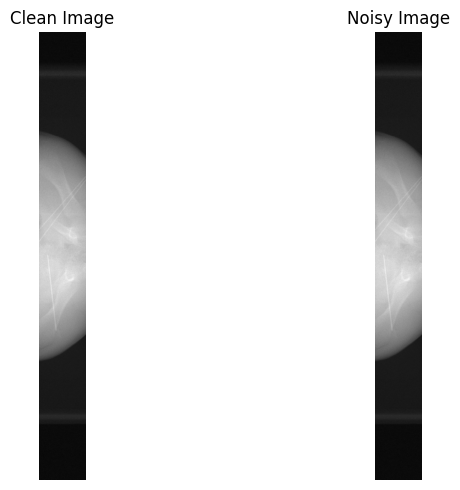

In [17]:
import numpy as np

def min_max_normalize(array, new_min=0, new_max=1):
    min_val = np.min(array)
    max_val = np.max(array)
    return (array - min_val) / (max_val - min_val) * (new_max - new_min) + new_min

# %%
# Setup environment and logger
device = setup_environment()
setup_logger()
logger.info("Loading data...")

# Load data
from convert_png_npy import convert_png_npy
from crop_numpy import crop_numpy
file_name='projection_0000'
dir = r"data\output_file_Th1_3000_1008" #'data'
file_format = 'npy'
if file_format == 'png':
    convert_png_npy(f'{file_name}.png', f'{file_name}.npy')
image, noisy_image, in_channels = load_data(dir, f'{file_name}.npy',f'{file_name}.npy')

# preprocessing
image, noisy_image = min_max_normalize(image, new_min=0, new_max=1), min_max_normalize(noisy_image, new_min=0, new_max=1)
desired_shape = None # (1024,1600,3)
if desired_shape is not None:
    image, noisy_image = crop_numpy(image, desired_shape), crop_numpy(noisy_image, desired_shape)
# Visualize the clean and noisy images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(prepare_for_display(image), cmap='gray' if in_channels == 1 else None)
plt.title("Clean Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prepare_for_display(noisy_image), cmap='gray' if in_channels == 1 else None)
plt.title("Noisy Image")
plt.axis('off')
plt.tight_layout()
plt.show()


### Visualizing Downsampling and ELS Transformation

min, max, mean tensor(0.) tensor(1.) tensor(0.3508)
down1 shape:  torch.Size([1, 1, 688, 72])
down2 shape:  torch.Size([1, 1, 688, 72])


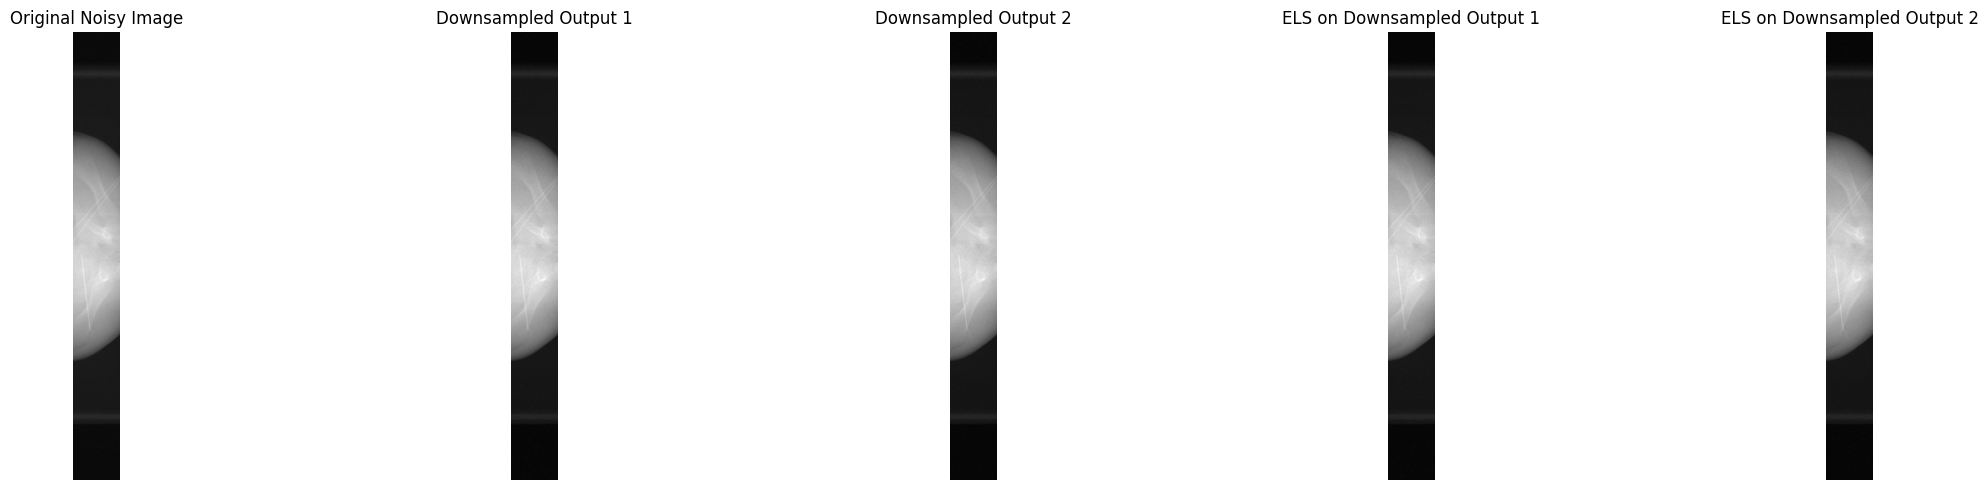

In [18]:
# Prepare the noisy image as a tensor
noisy_tensor = prepare_image(noisy_image, device)

# Apply downsampling
down1, down2 = Downsampler(noisy_tensor)
print("down1 shape: ", down1.shape)
print("down2 shape: ", down2.shape)

# Apply ELS to one of the downsampled images
els_down1 = ELS(down1)
els_down2 = ELS(down2)

def cast_to_rgb(out):
    return (out).astype(np.uint8)
# Convert tensors back to numpy arrays for display
noisy_disp = prepare_for_display(noisy_image)
down1_disp = prepare_for_display(restore_image(down1))
down2_disp = prepare_for_display(restore_image(down2))
els_disp1 = prepare_for_display(restore_image(els_down1))
els_disp2 = prepare_for_display(restore_image(els_down2))

# Plot the noisy image, downsampled outputs, and the ELS result
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
axes[0].imshow(noisy_disp, cmap='gray' if in_channels == 1 else None)
axes[0].set_title("Original Noisy Image")
axes[0].axis('off')

axes[1].imshow(down1_disp, cmap='gray' if in_channels == 1 else None)
axes[1].set_title("Downsampled Output 1")
axes[1].axis('off')

axes[2].imshow(down2_disp, cmap='gray' if in_channels == 1 else None)
axes[2].set_title("Downsampled Output 2")
axes[2].axis('off')

axes[3].imshow(els_disp1, cmap='gray' if in_channels == 1 else None)
axes[3].set_title("ELS on Downsampled Output 1")
axes[3].axis('off')

axes[4].imshow(els_disp2, cmap='gray' if in_channels == 1 else None)
axes[4].set_title("ELS on Downsampled Output 2")
axes[4].axis('off')

plt.tight_layout()
plt.show()


### Training the Denoising Model

In [29]:
# Initialize the model and training components
model = DenoisingPipeline(num_stages=2, patch_size=8, in_channels=in_channels).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = OneCycleLR(optimizer, max_lr=0.001, epochs=1000, steps_per_epoch=1)

alpha = 400
loss_function = LossFunction(device, alpha=alpha)

# Train the model
logger.info("Starting training...")
train_model(model, noisy_tensor, loss_function, optimizer, scheduler, epochs=1000)
logger.info("Training completed.")


2025-02-14 23:18:01.720 | INFO     | __main__:<module>:10 - Starting training...
2025-02-14 23:18:02.209 | INFO     | __main__:train_model:64 - Epoch 10/1000 - Loss: 0.005630
2025-02-14 23:18:02.510 | INFO     | __main__:train_model:64 - Epoch 20/1000 - Loss: 0.005574
2025-02-14 23:18:02.820 | INFO     | __main__:train_model:64 - Epoch 30/1000 - Loss: 0.005504
2025-02-14 23:18:03.126 | INFO     | __main__:train_model:64 - Epoch 40/1000 - Loss: 0.005411
2025-02-14 23:18:03.442 | INFO     | __main__:train_model:64 - Epoch 50/1000 - Loss: 0.005296
2025-02-14 23:18:03.747 | INFO     | __main__:train_model:64 - Epoch 60/1000 - Loss: 0.005169
2025-02-14 23:18:04.047 | INFO     | __main__:train_model:64 - Epoch 70/1000 - Loss: 0.005060
2025-02-14 23:18:04.348 | INFO     | __main__:train_model:64 - Epoch 80/1000 - Loss: 0.004985
2025-02-14 23:18:04.704 | INFO     | __main__:train_model:64 - Epoch 90/1000 - Loss: 0.004934
2025-02-14 23:18:05.025 | INFO     | __main__:train_model:64 - Epoch 100/

### Evaluating and Visualizing Denoising Results

In [30]:
model.eval()
logger.info("Number of parameters: {}".format(
    sum(p.numel() for p in model.parameters() if p.requires_grad)
))

with torch.no_grad():
    denoised, sigmas_list = model(noisy_tensor, return_sigmas=True)
    denoised_image = restore_image(denoised)

print(image.shape)
print(noisy_image.shape)
print(denoised_image.shape)
# Compute and log metrics
metrics = compute_metrics(image, noisy_image, denoised_image, in_channels, device)
for key, value in metrics.items():
    logger.info("{}: {:.4f}".format(key, value))


2025-02-14 23:18:51.710 | INFO     | __main__:<module>:2 - Number of parameters: 3638
2025-02-14 23:18:51.881 | INFO     | __main__:<module>:16 - psnr_noisy: inf
2025-02-14 23:18:51.881 | INFO     | __main__:<module>:16 - psnr_denoised: 39.1169
2025-02-14 23:18:51.882 | INFO     | __main__:<module>:16 - ssim_noisy: 1.0000
2025-02-14 23:18:51.883 | INFO     | __main__:<module>:16 - ssim_denoised: 0.8961


(1376, 144)
(1376, 144)
(1376, 144)


Saved numpy array as proj0000_denoised_alpha400.npy
Saved image as proj0000_denoised_alpha400.png


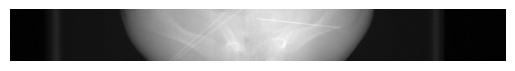

In [31]:
def save_output_image(denoised_image, filename="output_image", dpi=300):
    """
    Saves the model's output as both a PNG image and an NPY file.

    Parameters:
        tensor (torch.Tensor): The model output tensor.
        filename (str): Base filename (without extension).
    """
    image_array = denoised_image
    # Save as .npy
    np.save(f"{filename}.npy", image_array)
    print(f"Saved numpy array as {filename}.npy")

    # Save as .png
    # .astype(np.uint8)
    plt.imshow(image_array, cmap="gray")  # Use 'gray' for single-channel images
    plt.axis("off")  # Hide axes for better visualization
    plt.savefig(f"{filename}.png", dpi=dpi, bbox_inches='tight', pad_inches=0)
    print(f"Saved image as {filename}.png")
denoised_image = np.transpose(denoised_image)
save_output_image(denoised_image, f"proj0000_denoised_alpha{alpha}")

Saved numpy array as proj0000_denoised_alpha100.npy
Saved image as proj0000_denoised_alpha100.png


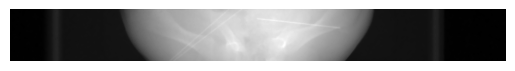

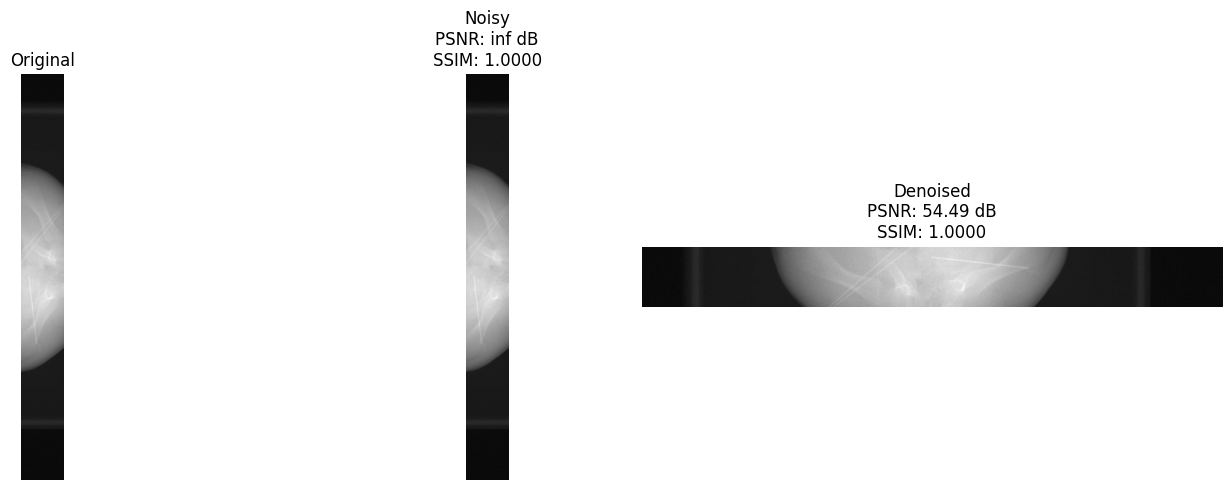

In [13]:
# Plot results: clean vs noisy vs denoised
plot_results(image, noisy_image, denoised_image, metrics, save_path='.')

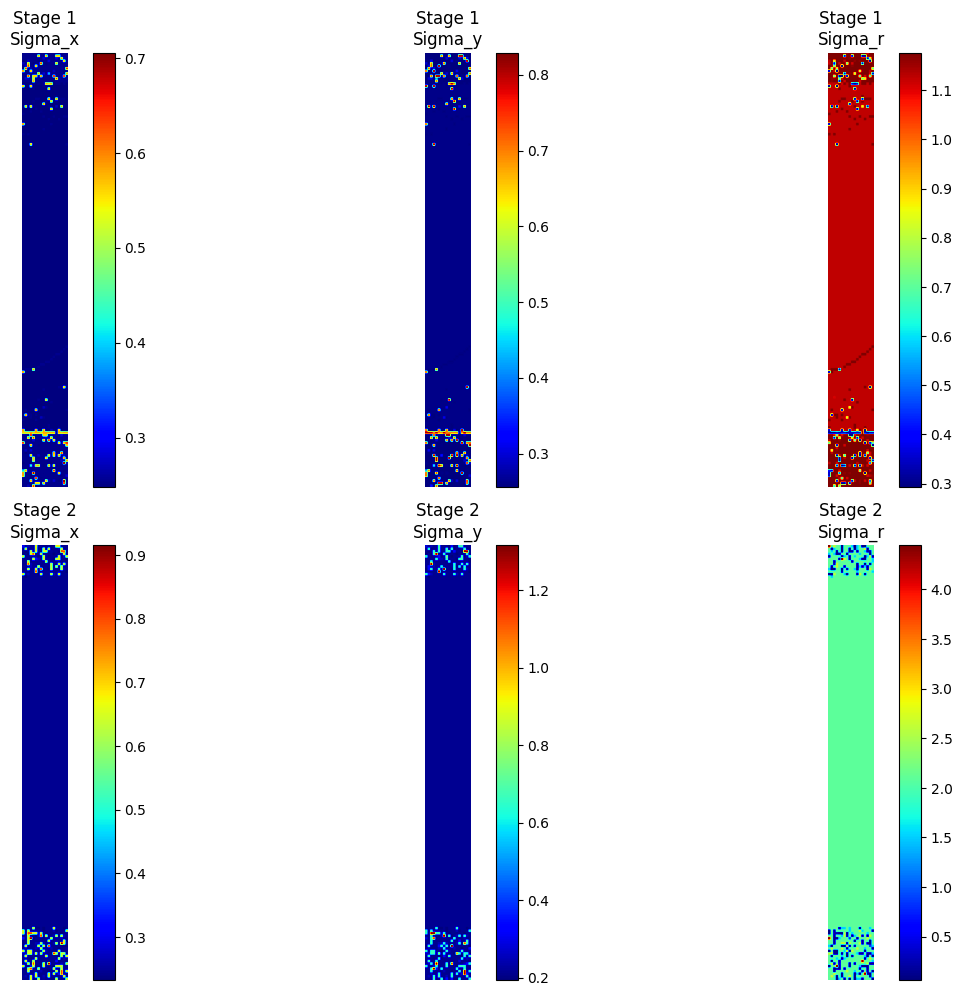

In [14]:
# Plot sigma maps from different stages
plot_sigmas(sigmas_list, save_path='.')